In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [5]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [6]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]- fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [7]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 125
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [9]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batch_norm1 = nn.BatchNorm2d(32)
    self.batch_norm2 = nn.BatchNorm2d(128)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.fc1 = nn.Linear(128,64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)
    self.fc4 = nn.Linear(10, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv6(x)))
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [10]:
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [11]:
focus_net.load_state_dict( torch.load("/content/drive/My Drive/Research/Cheating_data/Focus_net_weights/focus_net_6layer_cnn.pt"))

<All keys matched successfully>

Changing the last layer of Focus net

In [12]:
focus_net.fc4

Linear(in_features=10, out_features=2, bias=True)

In [13]:
print(focus_net.fc4)
print(focus_net.fc4.weight)
print(focus_net.fc4.bias)
temp = focus_net.fc4.weight.data
temp2 = focus_net.fc4.bias.data
focus_net.fc4 = nn.Linear(10,1).double()
focus_net.fc4.weight.data = torch.unsqueeze(temp[1,:], 0)
focus_net.fc4.bias.data = torch.unsqueeze(temp2[1], 0)
focus_net = focus_net.to("cuda")
print(focus_net.fc4.weight)
print(focus_net.fc4.bias)

Linear(in_features=10, out_features=2, bias=True)
Parameter containing:
tensor([[-0.3974,  0.2455,  0.2787, -0.4295, -0.5508,  0.8661, -0.2221, -0.6396,
          0.5014,  0.1486],
        [-0.1227,  0.1252, -0.0242,  0.3076,  0.7789, -0.7985, -0.2840,  0.6068,
         -0.5138,  0.2816]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([-0.2738,  0.0337], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([[-0.1227,  0.1252, -0.0242,  0.3076,  0.7789, -0.7985, -0.2840,  0.6068,
         -0.5138,  0.2816]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([0.0337], device='cuda:0', dtype=torch.float64, requires_grad=True)


In [14]:
focus_net.fc4

Linear(in_features=10, out_features=1, bias=True)

In [15]:
for params in focus_net.parameters():
  params.requires_grad = False

In [16]:
for params in focus_net.parameters():
  print(params)
  break;

Parameter containing:
tensor([[[[-1.0155e-01,  1.8843e-01, -3.7371e-01],
          [ 1.3882e-01,  3.1465e-01, -2.3114e-01],
          [-9.8712e-02,  1.7628e-01, -4.7682e-02]],

         [[-1.7731e-01,  2.7669e-01, -1.6959e-02],
          [-1.3041e-01,  1.1654e-01, -2.3628e-02],
          [-1.8088e-01,  1.7182e-02,  2.2703e-01]],

         [[ 2.6718e-01,  4.5371e-01, -1.1744e-02],
          [ 1.3648e-01,  2.1359e-02, -3.3651e-01],
          [-3.4207e-01, -2.8405e-01,  2.1965e-02]]],


        [[[-1.4553e-01, -3.1102e-01, -1.5143e-01],
          [-7.8231e-02, -2.3423e-01, -1.1562e-01],
          [ 4.3292e-03, -2.9985e-01, -1.6135e-01]],

         [[ 2.3403e-01, -7.7107e-02,  2.3617e-01],
          [ 7.9921e-03, -1.3719e-03, -1.2427e-01],
          [-2.4708e-03, -1.7089e-01,  1.4559e-01]],

         [[ 6.0008e-02,  2.2231e-01,  2.0222e-01],
          [ 2.2929e-01, -5.4566e-03,  7.7658e-02],
          [ 2.1009e-01, -2.0395e-02,  3.0434e-01]]],


        [[[ 1.8955e-02, -8.9080e-02, -7.6312

In [17]:
class Classification(nn.Module):
  def __init__(self, focus_net):
    super(Classification, self).__init__()
    self.module1 = focus_net
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")

    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    # print(x.shape)
    y1 = (F.relu(self.conv3(y1)))
    y1 =  y1.view(y1.size(0), -1)
    # print(x.shape)
    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)

    return y1 , x, y

In [18]:
focus_net.eval()
classify = Classification(focus_net).double()
classify = classify.to("cuda")

In [19]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [20]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [21]:
import torch.optim as optim
criterion_classify = nn.CrossEntropyLoss()
optimizer_classify = optim.SGD(classify.parameters(), lr=0.01, momentum=0.9)

In [22]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [23]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 30000 train images: 33 %
total correct 9919
total train set images 30000
focus_true_pred_true 9836 =============> FTPT : 32 %
focus_false_pred_true 83 =============> FFPT : 0 %
focus_true_pred_false 18880 =============> FTPF : 62 %
focus_false_pred_false 1201 =============> FFPF : 4 %
argmax_more_than_half ==================>  29071
argmax_less_than_half ==================>  929
30000


In [24]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 10000 test images: 33 %
total correct 3304
total train set images 10000
focus_true_pred_true 3277 =============> FTPT : 32 %
focus_false_pred_true 27 =============> FFPT : 0 %
focus_true_pred_false 6276 =============> FTPF : 62 %
focus_false_pred_false 420 =============> FFPF : 4 %
argmax_more_than_half ==================>  9672
argmax_less_than_half ==================>  328


In [25]:
nos_epochs = 1000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0
  classify.train()
  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    # zero the parameter gradients
    
    optimizer_classify.zero_grad()
    
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion_classify(outputs, labels) 
    loss.backward()
    optimizer_classify.step()
    
    running_loss += loss.item()
    mini = 60
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.005):
      break;

  if epoch % 5 == 0:
    col1.append(epoch+1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    print("train",col4)
  
    #************************************************************************
    #testing data set
    classify.eval()  
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs, alphas, avg_images = classify(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    print("test",col10)
    
print('Finished Training')

[1,    60] loss: 1.100
[1,   120] loss: 1.097
[1,   180] loss: 1.095
[1,   240] loss: 1.085
train [9836, 11861]
test [3277, 4726]
[2,    60] loss: 1.005
[2,   120] loss: 0.897
[2,   180] loss: 0.736
[2,   240] loss: 0.644
[3,    60] loss: 0.576
[3,   120] loss: 0.516
[3,   180] loss: 0.477
[3,   240] loss: 0.488
[4,    60] loss: 0.456
[4,   120] loss: 0.437
[4,   180] loss: 0.408
[4,   240] loss: 0.418
[5,    60] loss: 0.366
[5,   120] loss: 0.355
[5,   180] loss: 0.332
[5,   240] loss: 0.327
[6,    60] loss: 0.306
[6,   120] loss: 0.273
[6,   180] loss: 0.273
[6,   240] loss: 0.249
train [9836, 11861, 26823]
test [3277, 4726, 8656]
[7,    60] loss: 0.228
[7,   120] loss: 0.215
[7,   180] loss: 0.207
[7,   240] loss: 0.198
[8,    60] loss: 0.167
[8,   120] loss: 0.158
[8,   180] loss: 0.163
[8,   240] loss: 0.148
[9,    60] loss: 0.118
[9,   120] loss: 0.128
[9,   180] loss: 0.141
[9,   240] loss: 0.116
[10,    60] loss: 0.083
[10,   120] loss: 0.083
[10,   180] loss: 0.086
[10,   240]

In [26]:
for params in focus_net.parameters():
  print(params.requires_grad)
  break;

False


In [27]:
# for params in focus_net.parameters():
#   print(params)
#   break;

In [28]:
name = "8_focus_pretrained_classify_random_train_classify"

In [29]:
print(name)

8_focus_pretrained_classify_random_train_classify


In [30]:
torch.save(classify.state_dict(),"/content/drive/My Drive/Research/Cheating_data/16_experiments_on_cnn_6_3_layers/"+name+".pt")

In [31]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [32]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [33]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [34]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,29071,929,9836,83,18880,1201
1,1,30000,0,11861,2,18132,5
2,6,30000,0,26823,5,3172,0
3,11,30000,0,29345,3,650,2
4,16,29999,1,29815,2,181,2
5,21,30000,0,29801,0,199,0


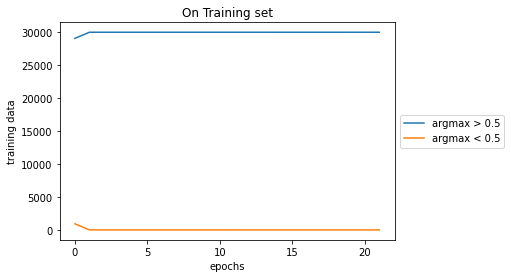

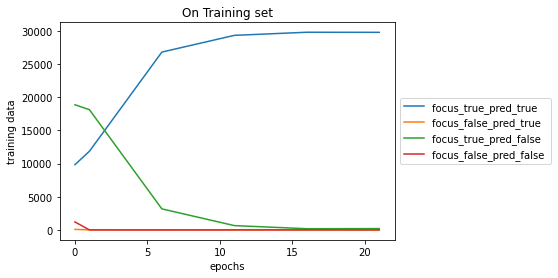

In [35]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [36]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,9672,328,3277,27,6276,420
1,1,9729,271,4726,271,4852,151
2,6,9733,267,8656,258,914,172
3,11,9733,267,9087,229,475,209
4,16,9723,277,9292,245,276,187
5,21,9734,266,9318,245,245,192


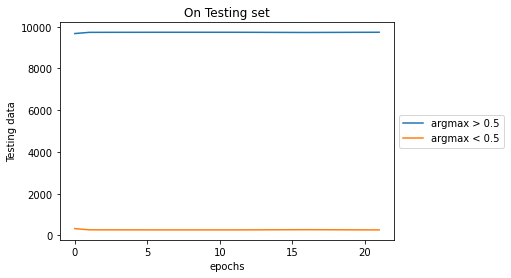

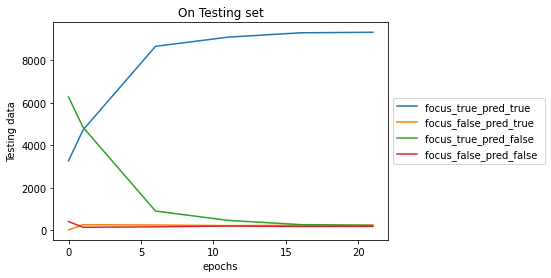

In [37]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [38]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

Accuracy of the network on the 30000 train images: 99 %
total correct 29987
total train set images 30000
focus_true_pred_true 29985 =============> FTPT : 99 %
focus_false_pred_true 2 =============> FFPT : 0 %
focus_true_pred_false 13 =============> FTPF : 0 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  30000
argmax_less_than_half ==================>  0
30000


In [39]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 10000 test images: 98 %
total correct 9888
total train set images 10000
focus_true_pred_true 9886 =============> FTPT : 98 %
focus_false_pred_true 2 =============> FFPT : 0 %
focus_true_pred_false 112 =============> FTPF : 1 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  10000
argmax_less_than_half ==================>  0


In [40]:
correct = 0
total = 0
# classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 30000 train images: 99 %
total correct 29985
total train set images 30000


In [41]:
correct = 0
total = 0

# classify.eval()
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 98 %
total correct 9888
total train set images 10000
